# 1 - Model Generation

This Jupyter notebook contains the entire model generation procedure used to construct logistic regression predictors for outcome of Ebola patients. The training data includes 579 pediatric from the [Ebola Data Platform](https://www.iddo.org/research-themes/ebola).

# Initialization

In [1]:
import pandas as pd
from os import listdir, makedirs
from os.path import isfile, join, exists

# This disables the warnings from RPy2 when R loads libraries that in turn load other dependencies
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)

# Use the RWinOut instead of rpy2.ipython to get output on windows 
# https://bitbucket.org/rpy2/rpy2/issues/125/set_writeconsole-not-working-on-windows
# https://github.com/vitorcurtis/RWinOut
#%load_ext RWinOut
%load_ext rpy2.ipython

In [2]:
%%R

# Load required R libraries

suppressPackageStartupMessages({
library(rms)
library(Hmisc)
library(glmnet)
library(mvnormtest)
library(naniar)
})    

In [3]:
%%R 

# Random seed for reproducibility. Is reset at the beginning of each 
# calculating that involves randomization, so cells can be run in 
# arbitrary order and still reproduce results.

random_seed <- 151

In [4]:
# Data file and modeling parameters

src_data_file = 'edp-data.csv' 

use_sat_impute = True # Use imputation from saturated model in all reduced models

normalize_ct = False

num_imp = 100   # Number of multiple imputations
num_boot = 200  # Number of bootstrap samples

In [5]:
# Some utility functions in Python

# Replaces PatientAge and FeverTemperature by Restricted Cubic Splines of order 3
def addRCSTerms(model_formula):
    formula = model_formula.replace('CT', 'rcs(CT,3)')
    formula = formula.replace('PatientAge', 'rcs(PatientAge,3)')    
    return formula

def makeImputeFormula(out_var, pred_vars):
    imp_vars = pred_vars.copy()
    formula = '~' + '+'.join([out_var] + imp_vars)
    return formula

def makeLogRegFormula(out_var, pred_vars):
    formula = addRCSTerms(out_var + '~' + '+'.join(pred_vars))
    return formula

def createModelFolder(path):
    if not exists(path):
        makedirs(path)
    return path

In [7]:
%%R -i normalize_ct

# Some utility functions in R

# Trims leading and trailing whitespaces
# https://stackoverflow.com/a/21882152
trim <- function(x) {
    return(gsub("(^[[:space:]]+|[[:space:]]+$)", "", x))
}

# Extract single frame from MI data
# https://stackoverflow.com/a/42820029
getImpute <- function(impute, data = src_data, im = 1) {
  cbind.data.frame(impute.transcan(x = impute, 
                                   imputation = im, 
                                   data = data, 
                                   list.out = TRUE, 
                                   pr = FALSE))
}

# Auxiliary (X^3)+
cubic <- function(u) {
   t <- max(0, u)
   return(t * t * t)
}

# Calculates the RCS term given the valuex, the term index, and the knots
rcsFun <- function(x, term, knots) {
    k <- length(knots) 
    j <- term
    t <- knots
    c <- (t[k] - t[1]) * (t[k] - t[1])
    value <- +cubic(x - t[j])
             -cubic(x - t[k - 1]) * (t[k] - t[j])/(t[k] - t[k-1])
             +cubic(x - t[k]) * (t[k - 1] - t[j])/(t[k] - t[k-1]) 
    return(value / c)  
}

# Arrange dataframe vars by position
# 'vars' must be a named vector, e.g. c("var.name"=1)
# https://stackoverflow.com/a/37009127
arrangeVars <- function(data, vars) {
    # Stop if not a data.frame (but should work for matrices as well)
    stopifnot(is.data.frame(data))

    # Sort out inputs
    data.nms <- names(data)
    var.nr <- length(data.nms)
    var.nms <- names(vars)
    var.pos <- vars
    
    # Sanity checks
    stopifnot(!any(duplicated(var.nms)), 
              !any(duplicated(var.pos)))
    stopifnot(is.character(var.nms), 
              is.numeric(var.pos))
    stopifnot(all(var.nms %in% data.nms))
    stopifnot(all(var.pos > 0), 
              all(var.pos <= var.nr))

    # Prepare output
    out.vec <- character(var.nr)
    out.vec[var.pos] <- var.nms
    out.vec[-var.pos] <- data.nms[ !(data.nms %in% var.nms) ]
    stopifnot( length(out.vec)==var.nr )

    # Re-arrange vars by position
    data <- data[, out.vec]
    return(data)
}

saveToTXT <- function(obj, dir, fn) {
    sink(paste0(dir, "/", fn), append=FALSE, split=FALSE)
    print(obj)
    sink()    
}

saveToPDF <- function(obj, dir, fn) {
    pdf(paste0(dir, "/", fn), useDingbats=FALSE)
    plot(obj)
    dev.off()
}

saveModelToCSV <- function(f, vars, dir) {
    terms = names(f$coefficients)
    coeff = unname(f$coefficients)

    # Extract RCS knots from model specs. 
    # This code is now specific to get the knots for age and fever temperature, 
    # but it could be generalized easily by providing a list with all the 
    # variables modeled as RCS.
    
    spec = specs(f)
    # print(str(spec)) # This is useful to understand the structure of the object
    
    ageIdx <- which(vars == "PatientAge")
    ctIdx <- which(vars == "CT")
    
    ageKnots <- spec$how.modeled[ageIdx, 2]
    ctKnots <- spec$how.modeled[ctIdx, 2]
    ageKnots <- trim(ageKnots)
    ctKnots <- trim(ctKnots)

    types <- rep.int("linear", length(terms))
    knots = rep.int("none", length(terms))

    age0 <- which(terms == "PatientAge")
    age1 <- which(terms == "PatientAge'")

    ct0 <- which(terms == "CT")
    ct1 <- which(terms == "CT'")
    
    types[age0] <- "RCS0"
    types[age1] <- "RCS1"
    knots[age1] <- ageKnots

    types[ct0] <- "RCS0"
    types[ct1] <- "RCS1"
    knots[ct1] <- ctKnots

    model <- data.frame("Term" = terms, "Coefficient" = coeff, "Type" = types, "Knots" = knots)
    write.table(model, file = paste0(dir, "/model.csv"), sep = ",", row.names=FALSE, qmethod = "double")    
}

saveDescription <- function(f, vars, dir) {
    print(f)
    saveRDS(f, paste0(dir, "/model.rds"))
    saveToTXT(f, dir, "model.txt")
    saveToTXT(specs(f), dir, "specs.txt")
    
    saveModelToCSV(f, vars, dir)    
}

saveEvaluation <- function(an, val, cal, dir) {
    print(val)
    plot(cal)

    saveToTXT(an, dir, "anova.txt")
    saveToPDF(an, dir, "anova.pdf")

    saveToTXT(val, dir, "validation.txt")
    saveToPDF(cal, dir, "calibration.pdf")
}

generateModel <- function(rseed, nimp, nboot, fimp, flgr, sdat, vars, dir) {
    set.seed(rseed)
    
    # Impute data and fit pooled model
    imp_res <- aregImpute(as.formula(fimp), data=sdat, n.impute=nimp)
    pool_mdl <- fit.mult.impute(as.formula(flgr), lrm, imp_res, data=sdat)

    # Calculate ANOVA and validation/calibration
    mdl_anv <- anova(pool_mdl)
    mdl_upd <- update(pool_mdl, x=TRUE, y=TRUE)
    mdl_val <- validate(mdl_upd, B=nboot)
    mdl_cal <- calibrate(mdl_upd, B=nboot)

    # Calculate distribution summaries for potential predictor variables
    saveDescription(f=pool_mdl, vars=vars, dir=dir)
    saveEvaluation(an=mdl_anv, val=mdl_val, cal=mdl_cal, dir=dir)

#     f <- mdl_upd    
#     df <- getImpute(impute=imp_res, im=1)
#     dd <- datadist(df)
    # Trick to reset the options, as described in https://www.burns-stat.com/the-options-mechanism-in-r/
#     oldopt <- options(datadist='dd') 
#     on.exit(options(oldopt))
    
    # Partial effects plot (from code in pp 279 in Harrel's Regression Modeling Strategies, figure 11.2)
    # Not working inside a function though, gives the error:
    # variable xxx does not have limits defined by datadist
#     pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
#     print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
#                  rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
#     dev.off()
 
    # Odds ratios plot for all variables in the model, showing interquartile-range ORs for continuous
    # predictors and simple ORs for categorical variables (figure 11.3 in same book)
    # Not working either inside a function
#     pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
#     plot(summary(f), log=TRUE)  
#     dev.off()

#     plot(summary(f), log=TRUE)
}

rcsAge <- function(x, term) {
    return(rcsFun(x, term, c(2, 10, 16)))
}

rcsCT <- function(x, term) {
    return(rcsFun(x, term, c(18.6, 25.2, 34.5)))
    
    # When using normalized CT
    #return(rcsFun(x, term, c(-1.1, -0.13, 1.4)))
}

selectVariables <- function(rseed, nimp, fimp, sdat, inc_ct) {
    set.seed(rseed)

    # Generate imputed datasets
    formula <- as.formula(fimp)
    imp_data <- aregImpute(formula, data=sdat, n.impute=nimp)

    # Setup the LASSO

    # alpha=0 is Ridge Regression (L1 norm penalty only)
    # alpha=0.5 is elastic net (mixture of L1 and L2 at a 50%)
    # alpha=1 is lasso (L2 norm penalty only)
    aelast = 0.5 # actually, we are using the elastic net

    # Set binomial as the prediction family so we run logistic regression
    predfam = "binomial"

    # Iterate over imputations
    coeffs <- list()
    for (i in 1:nimp) {
        df <- getImpute(impute = imp_data, im = i)

        # Transform the patient age and fever temperature into their RCS terms, that get
        # added to the data frame
        drops <- c()
        df$PatientAge1 <- mapply(rcsAge, df$PatientAge, 1)
        df$PatientAge2 <- mapply(rcsAge, df$PatientAge, 2) 
        drops <- c(drops, "PatientAge")

        if (inc_ct) {
          df$CT1 <- mapply(rcsCT, df$CT, 1)
          df$CT2 <- mapply(rcsCT, df$CT, 2)
          drops <- c(drops, "CT")         
        }

        # And remove the original variables 
        df <- df[ , !(names(df) %in% drops)]

        # Get outcome and predictor variables
        y <- as.matrix(df[,1])    
        x <- as.matrix(df[,2:ncol(df)])

        # Finds optimal lambda by cross-validation
        cv <- cv.glmnet(x, y, family=predfam, alpha=aelast, nfolds=10)
        lbest <- cv$lambda.min

        # Fit model
        fit <- glmnet(x, y, family=predfam, alpha=aelast, lambda=lbest)

        # Store coefficients  
        coeffs[[i]] <- coef(fit, s = "lambda.min")
    }

    ncoeff <- length(rownames(coeffs[[1]]))
    counts <- list()
    for (v in 1:ncoeff) {
        name <- rownames(coeffs[[1]])[v]
        c <- 0.0  
        for (i in 1:nimp) {
            if (0 < coeffs[[i]][v]) {
                c <- c + 1    
            }
        }
        counts[[name]] <- c/nimp  
    }

    # Sorting the counts https://stackoverflow.com/a/30651395
    counts <- counts[order(unlist(counts), decreasing=TRUE)]

    # And print out...
    res_names <- c()
    res_counts <- c()    
    for (k in names(counts)) {    
        n <- counts[[k]]
        cat(k, counts[[k]], '\n')
        res_names <- c(res_names, k)
        res_counts <- c(res_counts, n)
    }

    newList <- list("names" = res_names, "counts" = res_counts)
}

In [8]:
%%R -i src_data_file

# Load the source data

src_data <- read.table(src_data_file, sep=",", header=TRUE, na.strings="\\N")

# Splitting records by site
conarky_data <- src_data[src_data$SiteID == "CONAKRY", ]
nzerekore_data <- src_data[src_data$SiteID == "CTE-NZEREKORE", ]
elwa_data <- src_data[src_data$SiteID == "ELWA3", ]
msfbo_data <- src_data[src_data$SiteID == "MSF_Bo", ]
bong_data <- src_data[src_data$SiteID == "1-Bong", ]
lunsar_data <- src_data[src_data$SiteID == "2-Lunsar", ]
margibi_data <- src_data[src_data$SiteID == "3-Margibi", ]
kambia_data <- src_data[src_data$SiteID == "4-Kambia", ]
makeni_data <- src_data[src_data$SiteID == "5-Makeni", ]

summary_table = data.frame(do.call(cbind, lapply(src_data, summary)))
print(summary_table)

           SiteID              LOS             Death       PatientAge
Min.          579                1                 0                0
1st Qu. character                5                 0                5
Median  character                9                 0               10
Mean          579 9.90774907749078 0.404145077720207 9.45911485377202
3rd Qu. character               14                 1               14
Max.    character               31                 1               17
NA's          579               37                 0                0
               PatientSex               CT     AbdominalPain          Anorexia
Min.                    0      14.80000019                 0                 0
1st Qu.                 0            20.91                 0                 0
Median                  0      25.10000038                 0                 1
Mean    0.468048359240069 25.5967541034754 0.445054945054945 0.741596638655462
3rd Qu.                 1            29.47   

In [9]:
src_data = pd.read_csv(src_data_file, na_values='\\N')

mdead = len(src_data[src_data['Death'] == 1])
msurv = len(src_data[src_data['Death'] == 0])

print('Recommended maximum DOF:', str(round(min(mdead, msurv) / 15)))

all_vars = list(src_data.columns.values)

print()
print('All variables in the data:')
print(all_vars)
print("")

# Variable we want to predict
out_var = 'Death'

all_vars = all_vars[2:]

# Remove output variable
pred_vars = all_vars.copy()
pred_vars.remove(out_var)

# Remove variables with more than 50% of missing values.
mfrac = src_data.isnull().sum() / len(src_data)
tmp = pred_vars.copy()
for v in tmp:
    if 0.5 < mfrac[v]:
        print("Removing", v, "(missing " + str(int(mfrac[v] * 100)) + "%)")
        pred_vars.remove(v)
        continue

print()
print("All predictor variables:")
print(pred_vars)
print("")
print("Number of variables:", len(pred_vars))

Recommended maximum DOF: 16

All variables in the data:
['SiteID', 'LOS', 'Death', 'PatientAge', 'PatientSex', 'CT', 'AbdominalPain', 'Anorexia', 'AnyBleeding', 'JointPain', 'AstheniaWeakness', 'BoneMusclePain', 'Vomit', 'Diarrhoea', 'Breathlessness', 'Headache', 'SwallowingProblems', 'Fever', 'Hiccups', 'Nausea', 'Conjunctivitis', 'Malaria']

Removing Malaria (missing 76%)

All predictor variables:
['PatientAge', 'PatientSex', 'CT', 'AbdominalPain', 'Anorexia', 'AnyBleeding', 'JointPain', 'AstheniaWeakness', 'BoneMusclePain', 'Vomit', 'Diarrhoea', 'Breathlessness', 'Headache', 'SwallowingProblems', 'Fever', 'Hiccups', 'Nausea', 'Conjunctivitis']

Number of variables: 18


# Normality and MCAR tests

We now perform some calculations on all the a-priori model variables, to determine a number of important properties: normal distribution of the data, Missing Completely at Random (MCAR) condition.

We use the package mvnormtest to test for multivariate normality, using the Shapiro-Wilk test:

In [10]:
test_vars = pred_vars + ['Death']
print(test_vars)

['PatientAge', 'PatientSex', 'CT', 'AbdominalPain', 'Anorexia', 'AnyBleeding', 'JointPain', 'AstheniaWeakness', 'BoneMusclePain', 'Vomit', 'Diarrhoea', 'Breathlessness', 'Headache', 'SwallowingProblems', 'Fever', 'Hiccups', 'Nausea', 'Conjunctivitis', 'Death']


In [220]:
%%R -i test_vars

set.seed(random_seed)

# The test can only be performend on complete data
test_data <- src_data[unlist(test_vars)]
df <- test_data[complete.cases(test_data), ]
mat <- t(as.matrix(sapply(df, as.numeric)))
print(mshapiro.test(mat))


	Shapiro-Wilk normality test

data:  Z
W = 0.065878, p-value < 2.2e-16



Given that the data is normal, we can apply the Little's test for MCAR:

In [221]:
%%R -i test_vars
test_data <- src_data[unlist(test_vars)]
res <- mcar_test(test_data)

# http://naniar.njtierney.com/reference/mcar_test.html
print(res$statistic)
print(res$p.value)
print(res$missing.patterns)

[1] 1255.07
[1] 9.132075e-05
[1] 78


Since the test is significant, the MCAR hypthesis is rejected on the entire dataset. Let's apply the test separately on the data from each EDP site, to see if the non-randomness in the missing data can be attributed to the differences in data availability due to the location of the ETU's:

In [222]:
%%R -i test_vars

# Sites for which the MCAR test does not fail

print("CONAKRY")
test_data <- conarky_data[unlist(test_vars)]
res <- mcar_test(test_data)
print(res$statistic)
print(res$p.value)
print(res$missing.patterns)
print("")

print("ELWA3")
test_data <- elwa_data[unlist(test_vars)]
res <- mcar_test(test_data)
print(res$statistic)
print(res$p.value)
print(res$missing.patterns)
print("")

print("MSF_Bo")
test_data <- msfbo_data[unlist(test_vars)]
res <- mcar_test(test_data)
print(res$statistic)
print(res$p.value)
print(res$missing.patterns)
print("")

print("2-Lunsar")
test_data <- lunsar_data[unlist(test_vars)]
res <- mcar_test(test_data)
print(res$statistic)
print(res$p.value)
print(res$missing.patterns)
print("")

print("5-Makeni")
test_data <- makeni_data[unlist(test_vars)]
res <- mcar_test(test_data)
print(res$statistic)
print(res$p.value)
print(res$missing.patterns)
print("")

[1] "CONAKRY"
[1] 158.8174
[1] 0.6418093
[1] 11
[1] ""
[1] "ELWA3"
[1] 720.9349
[1] 0.002160745
[1] 45
[1] ""
[1] "MSF_Bo"
[1] 144.2914
[1] 0.5477577
[1] 13
[1] ""
[1] "2-Lunsar"
[1] 40.90081
[1] 0.47498
[1] 4
[1] ""
[1] "5-Makeni"
[1] 38.54778
[1] 0.5801667
[1] 4
[1] ""


The MCAR hypthesis cannot be rejected for the ELWA3 data. Inspecting separately:

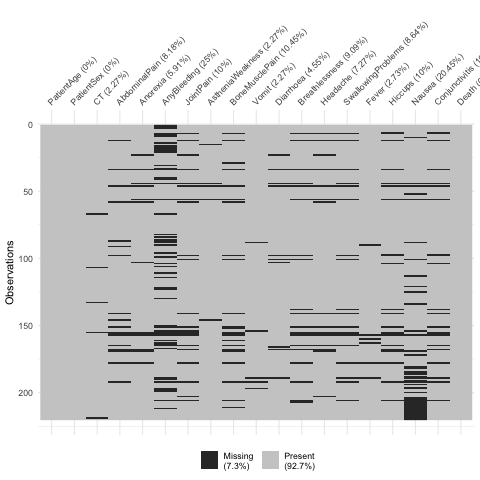

In [223]:
%%R -i test_vars

test_data <- elwa_data[unlist(test_vars)]
vis_miss(test_data)

From visual inspection of the missing patters, it could be that the MCAR hypothesis is rejected due to variables with more than 20% missingness (AnyBleeding and Nausea)

In [224]:
elwa_test_vars = test_vars.copy()
elwa_test_vars.remove('AnyBleeding')
elwa_test_vars.remove('Nausea')

In [225]:
%%R -i elwa_test_vars

test_data <- elwa_data[unlist(elwa_test_vars)]
res <- mcar_test(test_data)
print(res$statistic)
print(res$p.value)
print(res$missing.patterns)
print("")

[1] 409.4556
[1] 0.2733698
[1] 34
[1] ""


Removal of the high missingness variables in ELWA data results in accepting MCAR. Now, examining CTE-NZEREKORE, 1-Bongo, 3-Margibi, and 4-Kambia visually because those cause the MCAR test to crash

[1] "CTE-NZEREKORE"


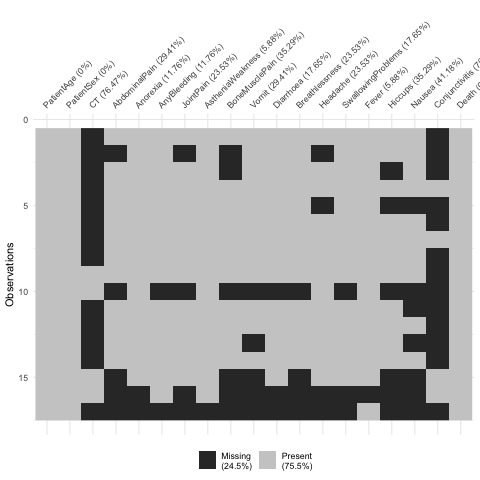

In [226]:
%%R -i test_vars

print("CTE-NZEREKORE")
test_data <- nzerekore_data[unlist(test_vars)]
vis_miss(test_data)

[1] "1-Bongo"


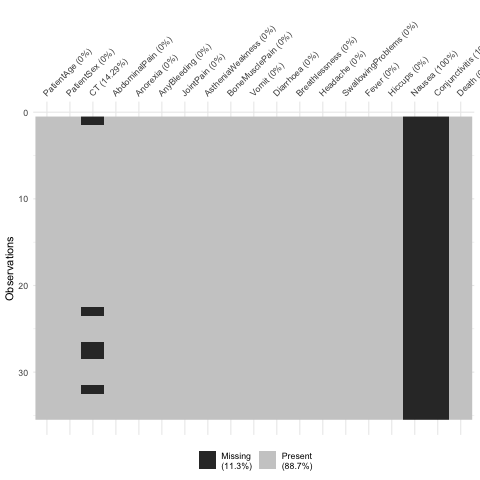

In [227]:
%%R -i test_vars

print("1-Bongo")
test_data <- bong_data[unlist(test_vars)]
vis_miss(test_data)

[1] "3-Margibi"


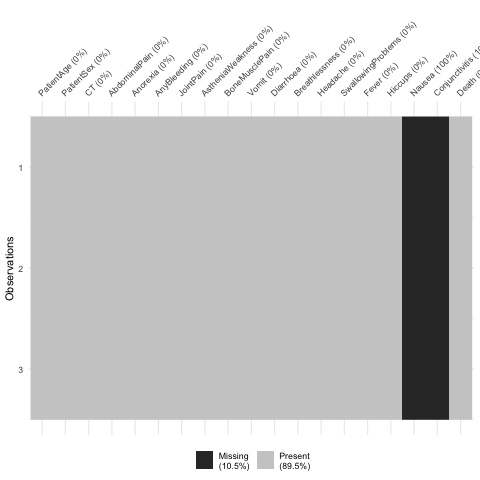

In [228]:
%%R -i test_vars

print("3-Margibi")
test_data <- margibi_data[unlist(test_vars)]
vis_miss(test_data)

[1] "4-Kambia"


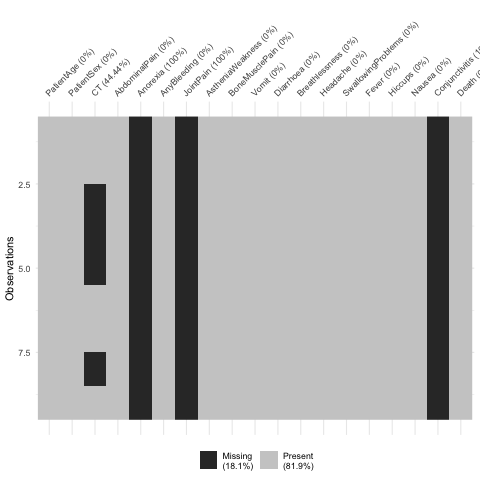

In [229]:
%%R -i test_vars

print("4-Kambia")
test_data <- kambia_data[unlist(test_vars)]
vis_miss(test_data)

Clearly, in all these cases the results of the test failing to run is entire columns missing. Removal of those would result in MCAR.

# Saturated model

We now fit a logistic regression model on all the variables.

In [11]:
# Setting the formulas for the imputation and logistic regression fitting of the fully 
# saturated model

sat_vars = pred_vars

sat_imp_formula = makeImputeFormula(out_var, sat_vars)
sat_lgr_formula = makeLogRegFormula(out_var, sat_vars)
print(sat_imp_formula)
print(sat_lgr_formula)

sat_folder = createModelFolder('saturated-model')

~Death+PatientAge+PatientSex+CT+AbdominalPain+Anorexia+AnyBleeding+JointPain+AstheniaWeakness+BoneMusclePain+Vomit+Diarrhoea+Breathlessness+Headache+SwallowingProblems+Fever+Hiccups+Nausea+Conjunctivitis
Death~rcs(PatientAge,3)+PatientSex+rcs(CT,3)+AbdominalPain+Anorexia+AnyBleeding+JointPain+AstheniaWeakness+BoneMusclePain+Vomit+Diarrhoea+Breathlessness+Headache+SwallowingProblems+Fever+Hiccups+Nausea+Conjunctivitis


Iteration 1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103 

Variance Inflation Factors Due to Imputation:

         Intercept         PatientAge        PatientAge'         PatientSex 
              1.80               1.11               1.10               1.10 
                CT                CT'      AbdominalPain           Anorexia 
              1.86               1.68               1.17               1.37 
       AnyBleeding          JointPain   AstheniaWeakness     BoneMusclePain 
              1.34               1.34               1.16               1.24 
             Vomit          Diarrhoea     Breathlessness           Headac

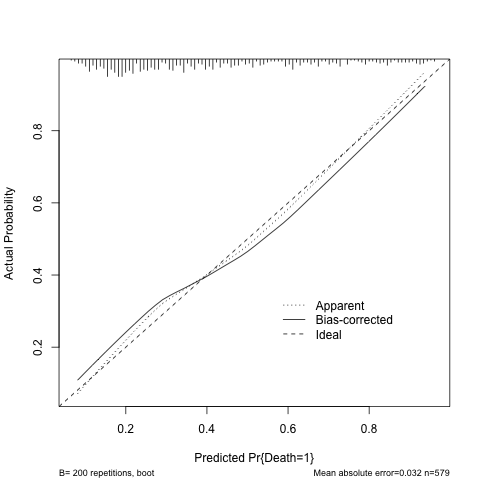

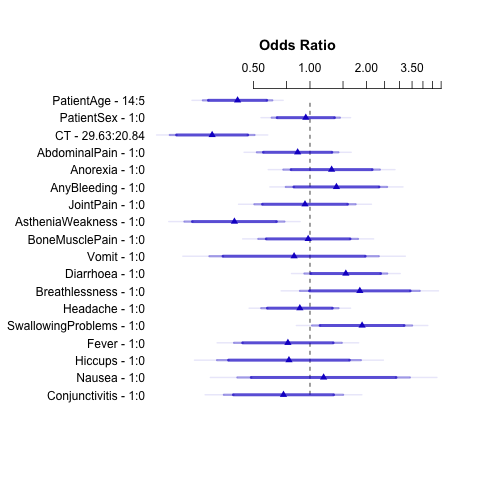

In [12]:
%%R -i num_imp,num_boot,sat_imp_formula,sat_lgr_formula,sat_folder,sat_vars

set.seed(random_seed)

# Impute data and fit pooled model
sat_impute <- aregImpute(as.formula(sat_imp_formula), data=src_data, n.impute=num_imp)
sat_model <- fit.mult.impute(as.formula(sat_lgr_formula), lrm, sat_impute, data=src_data)

# Calculate ANOVA and validation/calibration
sat_anova <- anova(sat_model)
sat_update <- update(sat_model, x=TRUE, y=TRUE)
sat_val <- validate(sat_update, B=num_boot)
sat_cal <- calibrate(sat_update, B=num_boot)

# Calculate distribution summaries for potential predictor variables
sat_datadist <- datadist(getImpute(impute = sat_impute, im = 1))

saveDescription(f=sat_model, vars=sat_vars, dir=sat_folder)
saveEvaluation(an=sat_anova, val=sat_val, cal=sat_cal, dir=sat_folder)

options(datadist='sat_datadist')
dir <- sat_folder
df <- getImpute(impute=sat_impute, im=1)
f <- sat_update

pdf(paste0(dir, "/partial.pdf"), useDingbats=FALSE)
print(ggplot(Predict(f), sepdiscrete='vertical', vnames='names', 
             rdata=df, histSpike.opts=list(frac=function(f) .1*f/max(f))))
dev.off() 

pdf(paste0(dir, "/or.pdf"), useDingbats=FALSE) 
plot(summary(f), log=TRUE)  
dev.off()

plot(summary(f), log=TRUE)

The saturated model has a AUC (C statistic) on the training data of 0.783, and an optimism in Dxy of 0.0709. Since C and Dxy are related by C = 0.5 + Dxy/2, the optimism corrected C is ~0.76, so the saturated model has a degree of overfitting to the data, although is not too bad. Some clinical symptoms have ORs lower than 1. This seems to indicate they increase the odds of survival, which does not make medical sense.

# Variable selection with penalized regression

Here we use [Elastic Net Regularization](https://en.wikipedia.org/wiki/Elastic_net_regularization) for variable selection. We run the regularized logistic regression with the [Glmnet package](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html) on each imputed dataset, and calculate how many times the coefficient for each variable over all the regressions is greater than zero. 

We are looking for variables that consistenly show non-negative coefficients since they represent clinical signs/symptoms at presentation that should be related with decreased changes of recovery. There are exceptions to this, for example cycletime has a negative coefficient since larger CT values indicate lower viral load and thus higher chances of recovery.

In [236]:
%%R -i num_imp,sat_imp_formula -o selection

selection <- selectVariables(random_seed, num_imp, sat_imp_formula, src_data, TRUE)

Iteration 1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103 
(Intercept) 1 
AnyBleeding 1 
Diarrhoea 1 
Breathlessness 1 
SwallowingProblems 1 
PatientAge2 0.99 
CT2 0.98 
Anorexia 0.97 
BoneMusclePain 0.64 
Nausea 0.25 
Vomit 0.11 
Conjunctivitis 0.1 
JointPain 0.07 
Hiccups 0.05 
Fever 0.03 
PatientSex 0.01 
AbdominalPain 0 
AstheniaWeakness 0 
Headache 0 
PatientAge1 0 
CT1 0 


We set the threshold for keeping a variable at +50% in the above list, meaning that the corresponding regression coefficient had to be positive at least in half of the models to be selected. As mentioned CT has a negative coefficient, and patient age and fever temperature are pre-determined, so we will only look at sign/symptoms above that threshold:

In [237]:
names = list(selection[0])
fraction = list(selection[1])

# These are predetermined, or not a model variable (i.e.: the intercept)
excluded = ['(Intercept)', 'PatientAge1', 'PatientAge2', 'CT1', 'CT2']

print('Variables to keep:')
for i in range(0, len(names)):
    if not names[i] in excluded and fraction[i] > 0.5:
        print(names[i], fraction[i])

Variables to keep:
AnyBleeding 1.0
Diarrhoea 1.0
Breathlessness 1.0
SwallowingProblems 1.0
Anorexia 0.97
BoneMusclePain 0.64


Based on this ranking, and following the information contained in [Colubri (2019)](https://www.thelancet.com/journals/eclinm/article/PIIS2589-5370(19)30096-3/fulltext) with regards to the factors that prognosticate mortality in Ebola:

> Several studies have already identified single symptoms statistically predictive for EVD mortality, such as confusion (15–17), diarrhoea,(16, 18) asthenia (15, 18), hiccups (14), haemorrhagic signs (14, 16, 19), dizziness (18), extreme fatigue (15), and high viral load (14, 17, 18, 20).

> 14. Hunt L, Gupta-Wright A, Simms V, Tamba F, Knott V, Tamba K, et al. Clinical presentation, biochemical, and haematological parameters and their association with outcome in patients with Ebola virus disease: an observational cohort study. The Lancet Infectious diseases. 2015 Nov;15(11):1292–9. pmid:26271406
> 15. Qin E, Bi J, Zhao M, Wang Y, Guo T, Yan T, et al. Clinical Features of Patients With Ebola Virus Disease in Sierra Leone. Clinical infectious diseases: an official publication of the Infectious Diseases Society of America. 2015 Aug 15;61(4):491–5.
> 16. WHO Ebola Response Team. Ebola virus disease in West Africa—the first 9 months of the epidemic and forward projections. The New England journal of medicine. 2014 Oct 16;371(16):1481–95. Pubmed Central PMCID: 4235004. pmid:25244186
> 17. Zhang X, Rong Y, Sun L, Liu L, Su H, Zhang J, et al. Prognostic Analysis of Patients with Ebola Virus Disease. PLoS neglected tropical diseases. 2015 Sep;9(9):e0004113. Pubmed Central PMCID: 4580459. pmid:26398207
> 18. Schieffelin JS, Shaffer JG, Goba A, Gbakie M, Gire SK, Colubri A, et al. Clinical illness and outcomes in patients with Ebola in Sierra Leone. The New England journal of medicine. 2014 Nov 27;371(22):2092–100. Pubmed Central PMCID: 4318555. pmid:25353969
> 19. Barry M, Traore FA, Sako FB, Kpamy DO, Bah EI, Poncin M, et al. Ebola outbreak in Conakry, Guinea: epidemiological, clinical, and outcome features. Medecine et maladies infectieuses. 2014 Dec;44(11–12):491–4. pmid:25391486
> 20. de La Vega MA, Caleo G, Audet J, Qiu X, Kozak RA, Brooks JI, et al. Ebola viral load at diagnosis associates with patient outcome and outbreak evolution. The Journal of clinical investigation. 2015 Dec;125(12):4421–8. Pubmed Central PMCID: 4665775. pmid:26551677

## Clinical-only variable selection

In [238]:
clin_vars = pred_vars.copy()
clin_vars.remove('CT')

sat_clin_imp_formula = makeImputeFormula(out_var, clin_vars)
print(sat_clin_imp_formula)

~Death+PatientAge+PatientSex+AbdominalPain+Anorexia+AnyBleeding+JointPain+AstheniaWeakness+BoneMusclePain+Vomit+Diarrhoea+Breathlessness+Headache+SwallowingProblems+Fever+Hiccups+Nausea+Conjunctivitis


In [239]:
%%R -i num_imp,sat_clin_imp_formula -o selection_clinical_only

selection_clinical_only <- selectVariables(random_seed, num_imp, sat_clin_imp_formula, src_data, FALSE)

Iteration 1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103 
(Intercept) 1 
AnyBleeding 1 
Diarrhoea 1 
Breathlessness 1 
SwallowingProblems 0.97 
Anorexia 0.96 
PatientAge2 0.7 
BoneMusclePain 0.51 
Conjunctivitis 0.09 
Hiccups 0.05 
JointPain 0.04 
Vomit 0.03 
Nausea 0.01 
PatientSex 0 
AbdominalPain 0 
AstheniaWeakness 0 
Headache 0 
Fever 0 
PatientAge1 0 


In [196]:
names_clin = list(selection_clinical_only[0])
fraction_clin = list(selection_clinical_only[1])

print('Variables to keep:')
for i in range(0, len(names_clin)):
    if not names_clin[i] in excluded and fraction_clin[i] > 0.5:
        print(names_clin[i], fraction_clin[i])

Variables to keep:
AnyBleeding 1.0
Diarrhoea 1.0
Breathlessness 1.0
SwallowingProblems 0.97
Anorexia 0.96
BoneMusclePain 0.51


# Age + CT + selected symptoms model

In [13]:
pars_vars = ['PatientAge', 'CT',
             'AnyBleeding', 'Diarrhoea', 'Breathlessness', 'SwallowingProblems', 'Anorexia', 'BoneMusclePain']

if use_sat_impute: 
    pars_imp_formula = sat_imp_formula 
else: 
    pars_imp_formula = makeImputeFormula(out_var, pars_vars)

pars_lgr_formula = makeLogRegFormula(out_var, pars_vars)
print(pars_imp_formula)
print(pars_lgr_formula)

pars_folder = createModelFolder('age-ct-symp-model')

~Death+PatientAge+PatientSex+CT+AbdominalPain+Anorexia+AnyBleeding+JointPain+AstheniaWeakness+BoneMusclePain+Vomit+Diarrhoea+Breathlessness+Headache+SwallowingProblems+Fever+Hiccups+Nausea+Conjunctivitis
Death~rcs(PatientAge,3)+rcs(CT,3)+AnyBleeding+Diarrhoea+Breathlessness+SwallowingProblems+Anorexia+BoneMusclePain


Iteration 1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103 

Variance Inflation Factors Due to Imputation:

         Intercept         PatientAge        PatientAge'                 CT 
              1.84               1.10               1.10               1.87 
               CT'        AnyBleeding          Diarrhoea     Breathlessness 
              1.67               1.33               1.15               1.18 
SwallowingProblems           Anorexia     BoneMusclePain 
              1.13               1.36               1.16 

Rate of Missing Information:

         Intercept         PatientAge        PatientAge'                 CT 
   

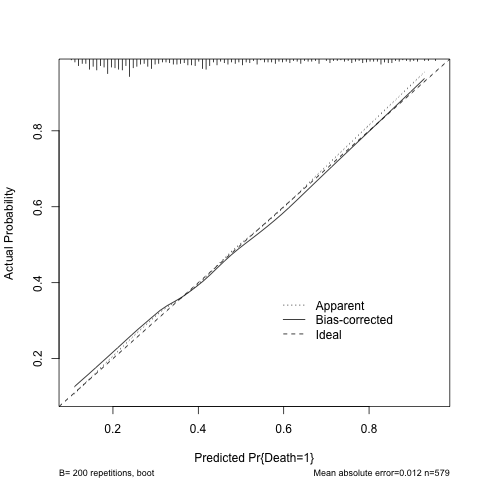

In [15]:
%%R -i num_imp,num_boot,pars_imp_formula,pars_lgr_formula,pars_vars,pars_folder

generateModel(random_seed, num_imp, num_boot, pars_imp_formula, pars_lgr_formula, 
              src_data, pars_vars, pars_folder)

# Age + selected symptoms model

In [16]:
pars_noct_vars = ['PatientAge', 
                  'AnyBleeding', 'Diarrhoea', 'Breathlessness', 'Anorexia', 'SwallowingProblems', 'BoneMusclePain']

if use_sat_impute: 
    pars_noct_imp_formula = sat_imp_formula 
else: 
    pars_noct_imp_formula = makeImputeFormula(out_var, pars_noct_vars)
    
pars_noct_lgr_formula = makeLogRegFormula(out_var, pars_noct_vars)
print(pars_noct_imp_formula)
print(pars_noct_lgr_formula)

pars_noct_folder = createModelFolder('age-symp-model')

~Death+PatientAge+PatientSex+CT+AbdominalPain+Anorexia+AnyBleeding+JointPain+AstheniaWeakness+BoneMusclePain+Vomit+Diarrhoea+Breathlessness+Headache+SwallowingProblems+Fever+Hiccups+Nausea+Conjunctivitis
Death~rcs(PatientAge,3)+AnyBleeding+Diarrhoea+Breathlessness+Anorexia+SwallowingProblems+BoneMusclePain


Iteration 1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103 

Variance Inflation Factors Due to Imputation:

         Intercept         PatientAge        PatientAge'        AnyBleeding 
              1.04               1.01               1.01               1.17 
         Diarrhoea     Breathlessness           Anorexia SwallowingProblems 
              1.07               1.10               1.24               1.10 

Rate of Missing Information:

         Intercept         PatientAge        PatientAge'        AnyBleeding 
              0.04               0.01               0.01               0.14 
         Diarrhoea     Breathlessness     

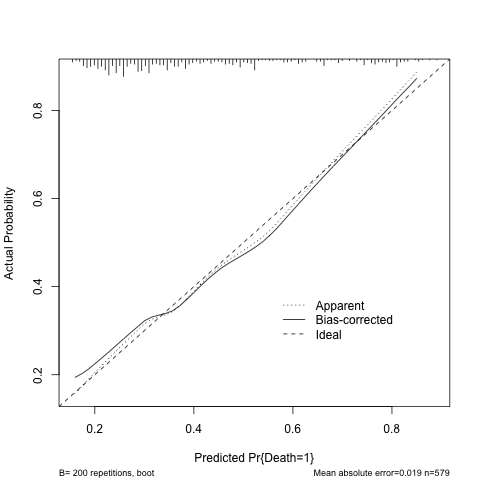

In [128]:
%%R -i num_imp,num_boot,pars_noct_imp_formula,pars_noct_lgr_formula,pars_noct_vars,pars_noct_folder

generateModel(random_seed, num_imp, num_boot, pars_noct_imp_formula, pars_noct_lgr_formula, 
              src_data, pars_noct_vars, pars_noct_folder)